In [79]:
%config InlineBackend

InlineBackend options
-------------------
InlineBackend.close_figures=<Bool>
    Current: True
    Close all figures at the end of each cell.
    When True, ensures that each cell starts with no active figures, but it also
    means that one must keep track of references in order to edit or redraw
    figures in subsequent cells. This mode is ideal for the notebook, where
    residual plots from other cells might be surprising.
    When False, one must call figure() to create new figures. This means that
    gcf() and getfigs() can reference figures created in other cells, and the
    active figure can continue to be edited with pylab/pyplot methods that
    reference the current active figure. This mode facilitates iterative editing
    of figures, and behaves most consistently with other matplotlib backends,
    but figure barriers between cells must be explicit.
InlineBackend.figure_format=<Unicode>
    Current: 'retina'
    The figure format to enable (deprecated use `figure_format

In [93]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

from metadata import parse_mmetsp_metadata, BOINK_DIR, DATA_DIR
import py
import pandas as pd
import seaborn as sns
from ficus import FigureManager
from astroML.plotting import hist

from collections import OrderedDict
import glob
import os
import re
from IPython.display import FileLink
import pyprind
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


In [22]:
mmetsp_metadata = parse_mmetsp_metadata(os.path.join(DATA_DIR, 'MMETSP_SraRunInfo_subset.csv'))

In [106]:
mmetsp_metadata[['ScientificName', 'SampleName']]

,ScientificName,SampleName
0,Erythrolobus australicus,MMETSP1353
1,Erythrolobus madagascarensis,MMETSP1354
2,Fabrea salina,MMETSP1345
3,Minutocellus polymorphus,MMETSP1322
4,Dictyocha speculum,MMETSP1174
5,Licmophora paradoxa,MMETSP1360
6,Staurosira,MMETSP1361
7,Leptocylindrus danicus,MMETSP1362
8,Asterionellopsis glacialis,MMETSP1394
9,Pseudo-nitzschia heimii,MMETSP1423


In [71]:
partition_data = []
for _, row in mmetsp_metadata.iterrows():
    try:
        path = os.path.join(row.ReadsDir, 'partitioned-assembly', 'global-stats.csv')
        data = pd.read_csv(path, header=None, names=['n_transcripts', 'n_components', 'n_tags', 'n_kmers'])
        sample_data = data.iloc[-1]
        sample_data.n_kmers = data.n_kmers.sum()
        sample_data['Species'] = row.ScientificName
        sample_data['Sample'] = row.SampleName
        sample_data['AssemblyPath'] = row.AssemblyPath

        partition_data.append(sample_data.copy())
    except FileNotFoundError:
        pass
partition_data = pd.DataFrame(partition_data).reset_index(drop=True)

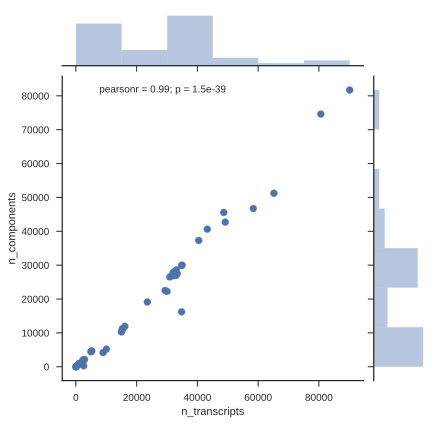

In [85]:
sns.jointplot(x=partition_data.n_transcripts, y=partition_data.n_components, )

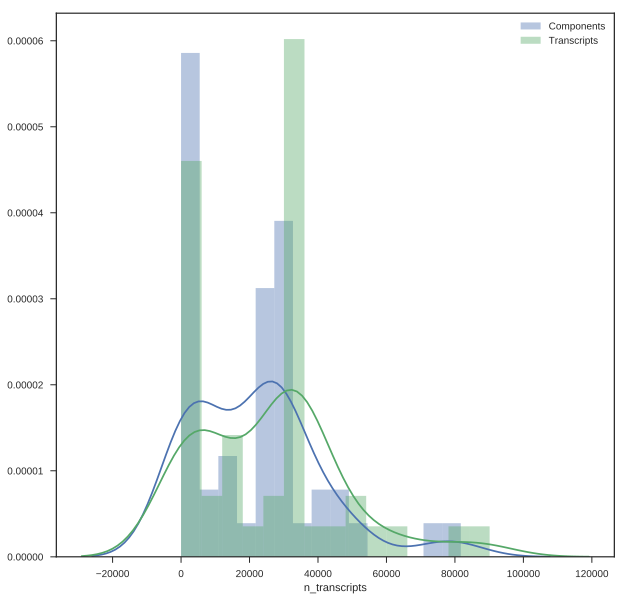

In [103]:
with FigureManager(show=True,  figsize=(10,10)) as (fig, ax):
    sns.distplot(partition_data.n_components, bins=15, ax=ax, label='Components')
    sns.distplot(partition_data.n_transcripts, bins=15, ax=ax, label='Transcripts')
    ax.legend()

In [19]:
# n, components, tags, new kmers

def parse_partition_data_dir(stats_dir, include_global=False, verbose=True):
    stats_files = [os.path.abspath(p) for p in glob.glob(os.path.join(stats_dir,'*.stats.csv'))]
    read_num_func = lambda fn: int(os.path.basename(fn).split('.')[0])
    stats_files.sort(key=read_num_func)
    if verbose:
        print('Parsing {0} partition files from {1}'.format(len(stats_files), stats_dir))
        bar = pyprind.ProgBar(len(stats_files), monitor=False)
    
    data = OrderedDict()
    for filename in stats_files:
        df = pd.read_csv(filename, header=None, names=['comp_id', 'n_tags', 'mean_cov'])
        data[read_num_func(filename)] = df
        if verbose:
            bar.update()
    return data

In [20]:
parse_partition_data_dir('data/Skeletonema_marinoi/SRR1300462/partitioned-assembly/')

0%  100%
[##  ] | ETA: 00:00:00 | ETA: 00:00:00

Parsing 4 partition files from data/Skeletonema_marinoi/SRR1300462/partitioned-assembly/


[####] | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00


OrderedDict([(10000,       comp_id  n_tags  mean_cov
              0           0      33  1.000000
              1           1      24  1.000000
              2           2      33  1.000000
              3           3      99  1.000000
              4           4      22  1.000000
              5           5      21  1.000000
              6           6      18  1.000000
              7           7      55  1.000000
              8           8      30  1.000000
              9           9      15  1.000000
              10         10      52  1.000000
              11         11      81  1.000000
              12         12      26  1.000000
              13         13      31  1.000000
              14         14      34  1.000000
              15         15      43  1.000000
              16         16      37  1.000000
              17         17      26  1.000000
              18         18      35  1.000000
              19         19      52  1.000000
              20         20

In [10]:
glob.glob('**/global-stats.csv', recursive=True)

['data/Skeletonema_marinoi/SRR1300462/partitioned-assembly/global-stats.csv',
 'data/Asterionellopsis_glacialis/SRR1300451/partitioned-assembly/global-stats.csv',
 'data/Lessardia_elongata/SRR1300468/partitioned-assembly/global-stats.csv',
 'data/Moneuplotes_crassus/SRR1300459/partitioned-assembly/global-stats.csv',
 'data/Chaetoceros_sp./SRR1300463/partitioned-assembly/global-stats.csv',
 'data/Climacostomum_virens/SRR1300461/partitioned-assembly/global-stats.csv',
 'data/Elphidium_margaritaceum/SRR1300475/partitioned-assembly/global-stats.csv',
 'data/Pseudo-nitzschia_heimii/SRR1300452/partitioned-assembly/global-stats.csv',
 'data/Prorocentrum_lima/SRR1300465/partitioned-assembly/global-stats.csv',
 'data/Thalassiosira_weissflogii/SRR1300491/partitioned-assembly/global-stats.csv',
 'data/Thalassiosira_weissflogii/SRR1300482/partitioned-assembly/global-stats.csv',
 'data/Thalassiosira_weissflogii/SRR1300488/partitioned-assembly/global-stats.csv',
 'data/Thalassiosira_weissflogii/SRR1